In [1]:
from pathlib import Path
import pickle

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [3]:
methods = {
    'sgd-rb-1': ('ogd', "olive", "dashdot"),
    'sgd-rb-10': ('r-sgd-10', plt.cm.Greens(0.9), "dashdot"),
    
    'adam-rb-1': ('r-adam-1', plt.cm.Reds(0.5), "--"),
    'adam-rb-10': ('r-adam-10', plt.cm.Reds(0.9), "--"),
    
    'fdekf': ('fdekf', 'black', "dotted"),
    'vdekf': ('vdekf', 'dimgray', "dotted"),
    
    'lofi-1': ('lofi-01', plt.cm.Blues(0.5), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.9), "-"),
}

n_iter = 20

# Figure 1(c)

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./permuted/fashion_mnist/mlp/nll
%env REBAYES_CONFIG=../configs/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_classification_experiments.py --problem permuted  --n_iter 20
%run ../../run_classification_experiments.py --problem permuted --n_iter 20 \
    --hyperparameter eval_only

In [4]:
n_tasks, ntrain_per_task = 10, 300
boundaries_lg = [i for i in range(ntrain_per_task, (ntrain_per_task*n_tasks)+1, ntrain_per_task)]

In [6]:
path_fmnist_mlp = Path(Path.cwd(), "permuted", "fashion_mnist", "mlp", "nll")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [10,]],
    "fdekf", "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_miscl_fmnist_mlp, results_nll_fmnist_mlp = {}, {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    results_miscl_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["miscl"]["current"], axis=0),
        "std": jnp.std(curr_result["miscl"]["current"], axis=0),
    }
    results_nll_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["nll"]["current"], axis=0),
        "std": jnp.std(curr_result["nll"]["current"], axis=0),
    }

In [7]:
kernel_size = 10
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

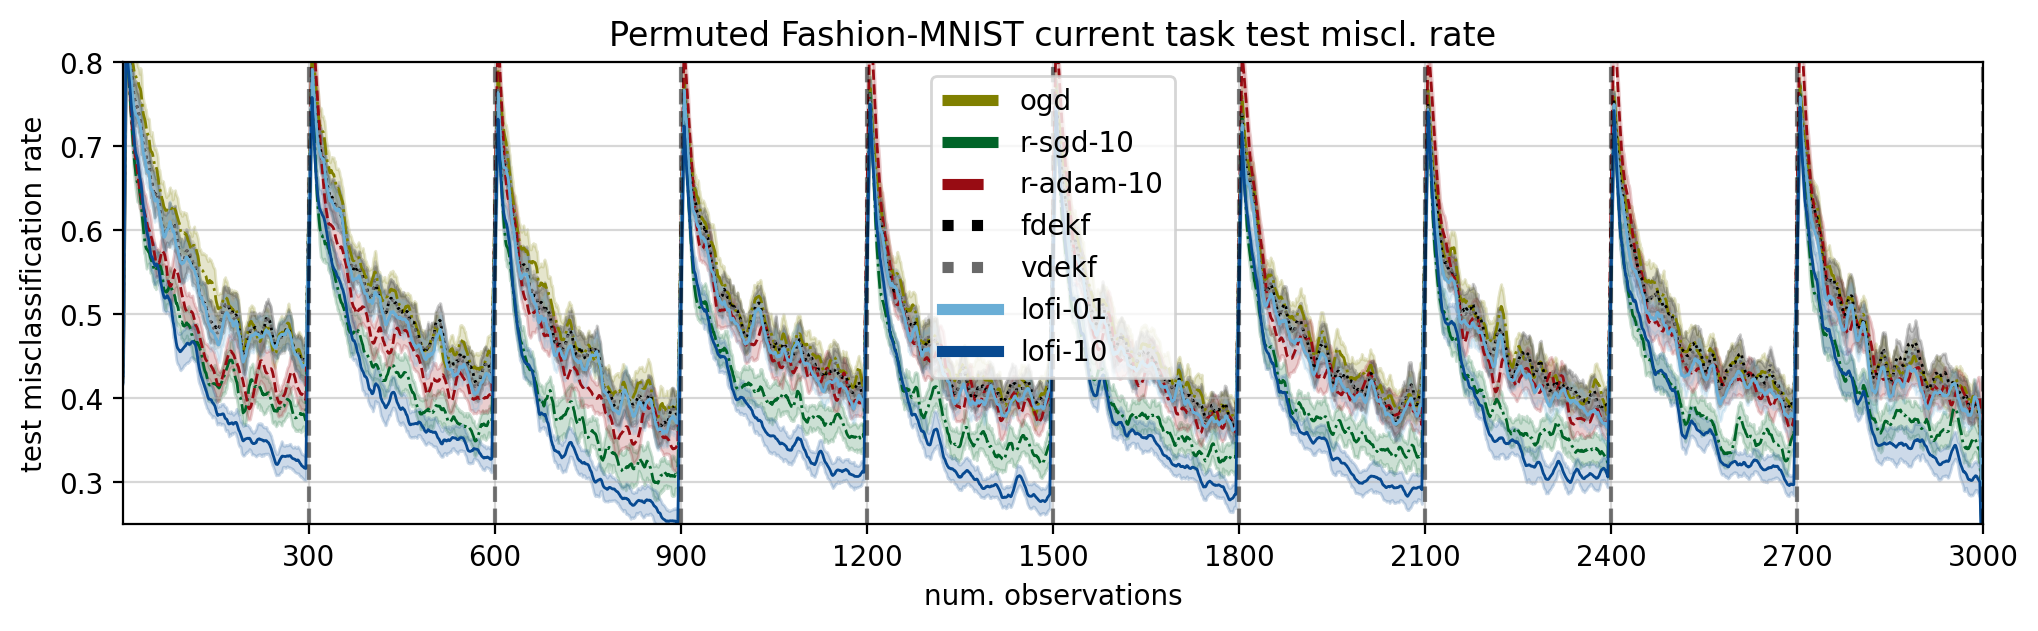

In [8]:
fig, ax = plt.subplots(figsize=(12, 3))
for key, val in results_miscl_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    if key == 'offline_sgd':
        ax.axhline(y=val, color = 'gray', linestyle = '--', label=methods[key]);
    else:
        label, color, ls = methods[key]
        ax.plot(mean, label=label, c=color, linewidth=1.0, linestyle=ls)
        ax.fill_between(
            jnp.arange(mean.shape[0]),
            mean - std / jnp.sqrt(n_iter),
            mean + std / jnp.sqrt(n_iter),
            alpha=0.2,
            color=color,
        )
# Task boundaries
for b in boundaries_lg:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(boundaries_lg)
ax.set_xlabel('num. observations')
ax.set_ylabel('test misclassification rate');
ax.set_xlim(0, 3_000)
ax.set_ylim(0.25, 0.8)
ax.set_title(f'Permuted Fashion-MNIST current task test miscl. rate')
ax.grid(alpha=0.5)
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
fig.savefig(Path(path_fmnist_mlp, 'nonstationary-pmnist-clf-curr-miscl.pdf'), bbox_inches='tight')

# Figure 13

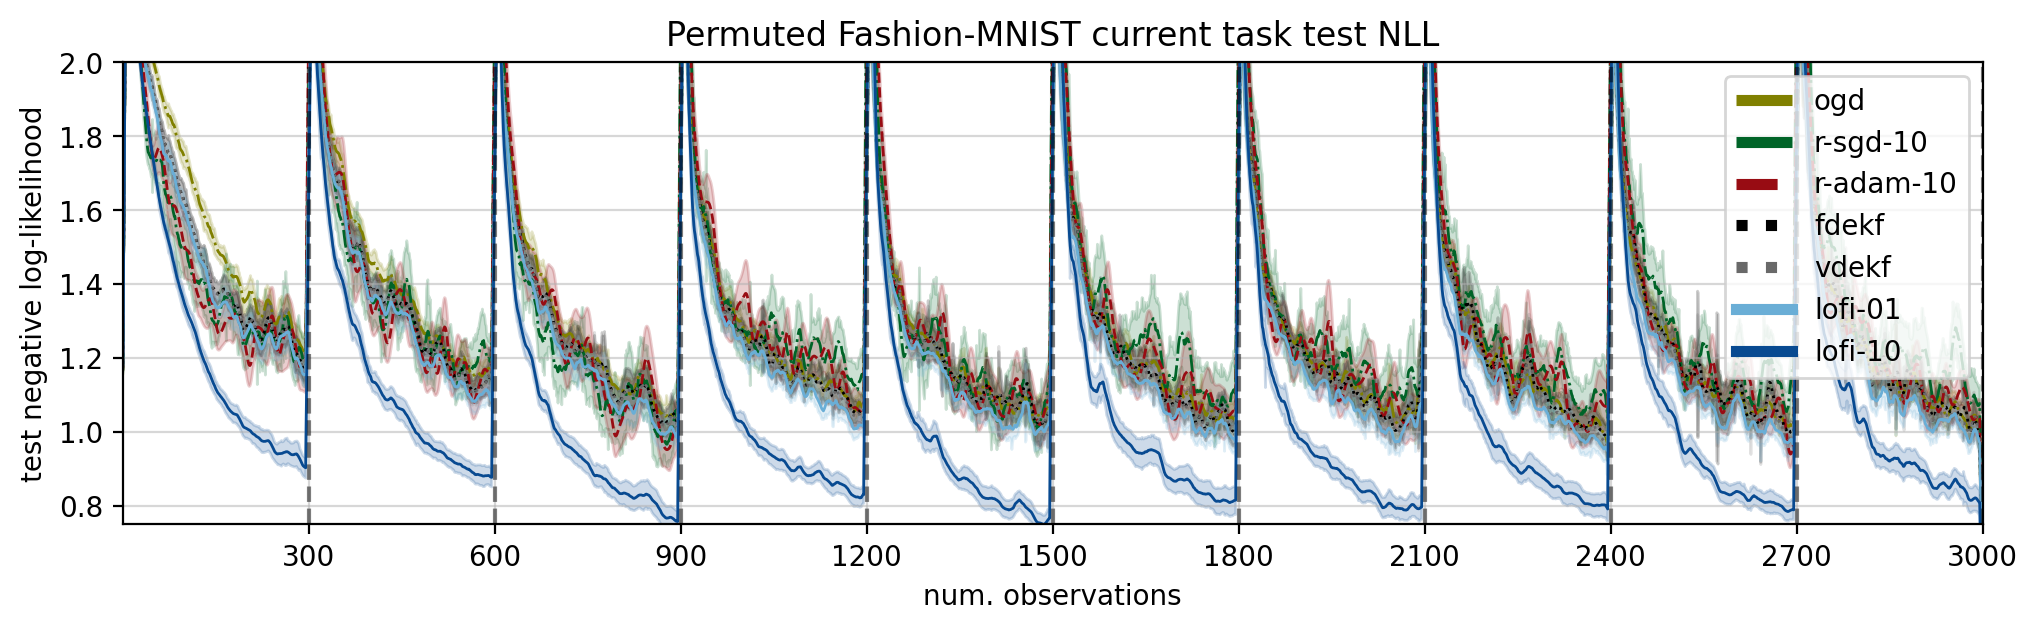

In [9]:
fig, ax = plt.subplots(figsize=(12, 3))
for key, val in results_nll_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    if key == 'offline_sgd':
        ax.axhline(y=val, color = 'gray', linestyle = '--', label=methods[key]);
    else:
        label, color, ls = methods[key]
        ax.plot(mean, label=label, c=color, linewidth=1.0, linestyle=ls)
        ax.fill_between(
            jnp.arange(mean.shape[0]),
            mean - std / jnp.sqrt(n_iter),
            mean + std / jnp.sqrt(n_iter),
            alpha=0.2,
            color=color,
        )
# Task boundaries
for b in boundaries_lg:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(boundaries_lg)
ax.set_xlabel('num. observations')
ax.set_ylabel('test negative log-likelihood');
ax.set_xlim(0, 3_000)
ax.set_ylim(0.75, 2.0)
ax.set_title(f'Permuted Fashion-MNIST current task test NLL')
ax.grid(alpha=0.5)
leg = ax.legend(loc=1)
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
fig.savefig(Path(path_fmnist_mlp, 'nonstationary-pmnist-clf-curr-nll.pdf'), bbox_inches='tight')

# Figure 14

In [10]:
lofi_methods = {
    'lofi-1': ('lofi-01', plt.cm.Blues(0.2), "-"),
    'lofi-5': ('lofi-05', plt.cm.Blues(0.4), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.6), "-"),
    'lofi-20': ('lofi-20', plt.cm.Blues(0.8), "-"),
    'lofi-50': ('lofi-50', plt.cm.Blues(1.0), "-"),
}

n_iter = 20

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./permuted/fashion_mnist/mlp/nll
%env REBAYES_CONFIG=../configs/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_classification_experiments.py  --problem permuted \
#     --ranks 1 5 10 20 50 --n_iter 20
%run ../../run_classification_experiments.py  --problem permuted \
    --ranks 1 5 10 20 50 --n_iter 20 --hyperparameter eval_only

In [11]:
n_tasks, ntrain_per_task = 10, 300
boundaries_lg = [i for i in range(ntrain_per_task, (ntrain_per_task*n_tasks)+1, ntrain_per_task)]

In [12]:
from jax.tree_util import tree_map

path_fmnist_mlp = Path(Path.cwd(), "permuted", "fashion_mnist", "mlp", "nll")

lofi_fmnist_mlp = (
    *[f"lofi-{rank}" for rank in [1, 5, 10, 20, 50]],
)

lofi_curr_fmnist_mlp, lofi_cum_fmnist_mlp = {}, {}

for method in lofi_fmnist_mlp:
    with open(Path(path_fmnist_mlp, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    lofi_curr_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["miscl"]["current"], axis=0),
        "std": jnp.std(curr_result["miscl"]["current"], axis=0),
    }
    lofi_cum_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["miscl"]["overall"], axis=0),
        "std": jnp.std(curr_result["miscl"]["overall"], axis=0),
    }

In [13]:
kernel_size = 10
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

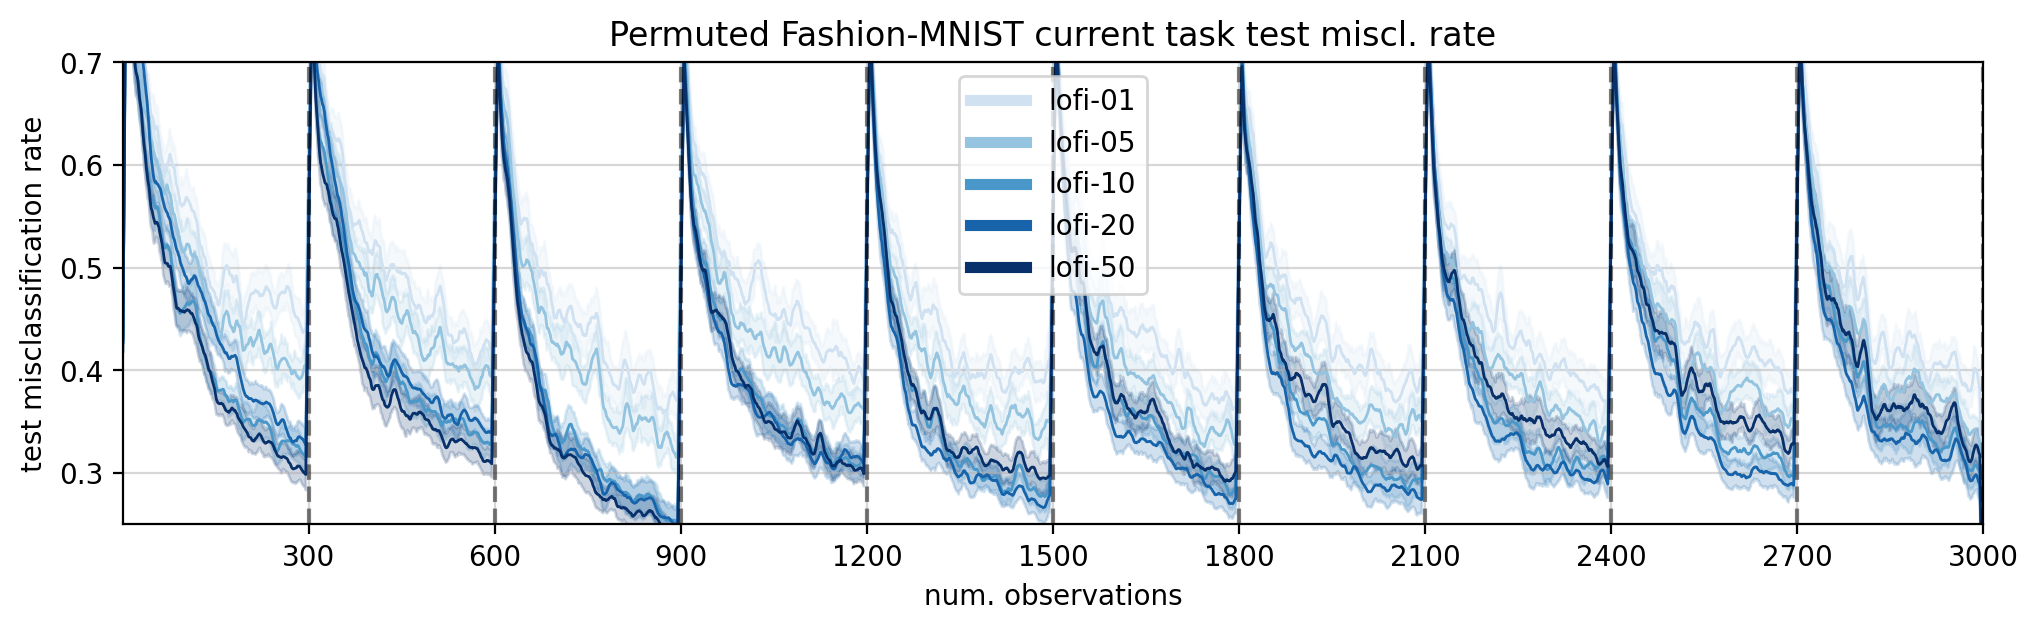

In [14]:
fig, ax = plt.subplots(figsize=(12, 3))
for key, val in lofi_curr_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    if key == 'offline_sgd':
        ax.axhline(y=val, color = 'gray', linestyle = '--', label=methods[key]);
    else:
        label, color, ls = lofi_methods[key]
        ax.plot(mean, label=label, c=color, linewidth=1.0, linestyle=ls)
        ax.fill_between(
            jnp.arange(mean.shape[0]),
            mean - std / jnp.sqrt(n_iter),
            mean + std / jnp.sqrt(n_iter),
            alpha=0.2,
            color=color,
        )
# Task boundaries
for b in boundaries_lg:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(boundaries_lg)
ax.set_xlabel('num. observations')
ax.set_ylabel('test misclassification rate');
ax.set_xlim(0, 3_000)
ax.set_ylim(0.25, 0.7)
ax.set_title(f'Permuted Fashion-MNIST current task test miscl. rate')
ax.grid(alpha=0.5)
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
fig.savefig(Path(path_fmnist_mlp, 'nonstationary-pmnist-clf-lofi-curr-miscl.pdf'), bbox_inches='tight')